<img src="https://www.nlplanet.org/images/NLP_tasks.png" width="800">


# Topic Modeling
## Example: Lenovo Amazon Customer Review 
<img src="https://image.cnbcfm.com/api/v1/image/107168822-1671538596693-gettyimages-1443880219-2a5a9193_8cc60243-f700-4596-b223-91ea0c1508c3.jpeg?v=1685620344&w=1920&h=1080" width="300">
<img src="https://img.money.com/2019/12/amazon_review-1.jpg" width="250">

# Install Package

In [0]:
! pip install gensim
! pip install bokeh
! pip install pyLDAvis
! pip install BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 43.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 37.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing instal

In [0]:
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

from IPython.display import clear_output
# import pyLDAvis
import pyLDAvis.gensim
# import cloudpickle as pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
from matplotlib.patches import Rectangle

from sklearn.manifold import TSNE
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.embed import components, file_html
from bokeh.resources import CDN

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [0]:
data_path = "/dbfs/FileStore/tables/K8_Reviews_v0_2.csv"
review_df = pd.read_csv(data_path).drop('sentiment', axis = 1)
print(review_df.info())
review_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  14675 non-null  object
dtypes: object(1)
memory usage: 114.8+ KB
None


,review
0,Good but need updates and improvements
1,"Worst mobile i have bought ever, Battery is dr..."
2,when I will get my 10% cash back.... its alrea...
3,Good
4,The worst phone everThey have changed the last...


# Prepare Data

In [0]:
review_df['cleaned_review'] = review_df['review'].apply(lambda x: str(x).lower())
review_df['cleaned_review'] = review_df['cleaned_review'].str.replace(r'[^a-zA-Z\s]', ' ',regex=True) 
review_df['cleaned_review'] = review_df['cleaned_review'].str.replace(r'\s{2,}', ' ',regex=True)
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x: word_tokenize(x))
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x:[word for word in x if word not in stopwords.words("english") and len(word) > 3 and word.isalpha()])
review_df = review_df[review_df['cleaned_review'].map(lambda x: len(x)) > 1].reset_index(drop=True)
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])
print(review_df.head(5))
print()

data_ready = review_df['cleaned_review'].values.tolist()
print(type(data_ready))
print()
print(data_ready[:5])
print()

# create dictionary
id2word = corpora.Dictionary(data_ready)
print(" === dictionary === ")
print(id2word)
print()

# create corpos: term document frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
print(corpus[:5])
print()

                                              review                                     cleaned_review
0             Good but need updates and improvements                  [good, need, update, improvement]
1  Worst mobile i have bought ever, Battery is dr...  [worst, mobile, bought, ever, battery, drainin...
2  when I will get my 10% cash back.... its alrea...                     [cash, back, already, january]
3  The worst phone everThey have changed the last...  [worst, phone, everthey, changed, last, phone,...
4  Only I'm telling don't buyI'm totally disappoi...  [telling, buyi, totally, disappointedpoor, bat...

<class 'list'>

[['good', 'need', 'update', 'improvement'], ['worst', 'mobile', 'bought', 'ever', 'battery', 'draining', 'like', 'hell', 'backup', 'hour', 'internet', 'us', 'even', 'mobile', 'idle', 'getting', 'discharged', 'biggest', 'amazon', 'lenove', 'expected', 'making', 'full', 'saying', 'battery', 'booster', 'charger', 'fake', 'take', 'least', 'hour', 'fully', 'char

# Latent Dirichlet Allocation

In [0]:
# Computing coherence score for different sizes of topics

def calculate_topic_cv(texts, dictionary, topic_range):
  cv_score =[]
  topic_num = []
  for i in range(2, topic_range):
    topic_num.append(i)
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(corpus=corpus, id2word=id2word, num_topics=i, passes=10, random_state=42)
    cv_score.append(CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence())
    clear_output()
  return topic_num, cv_score

topic_num, cv_score = calculate_topic_cv(data_ready, id2word, 11)
pd.DataFrame(zip(topic_num, cv_score), columns=['Topic','Coherence_Score']).set_index('Topic').sort_values('Coherence_Score', ascending=False)

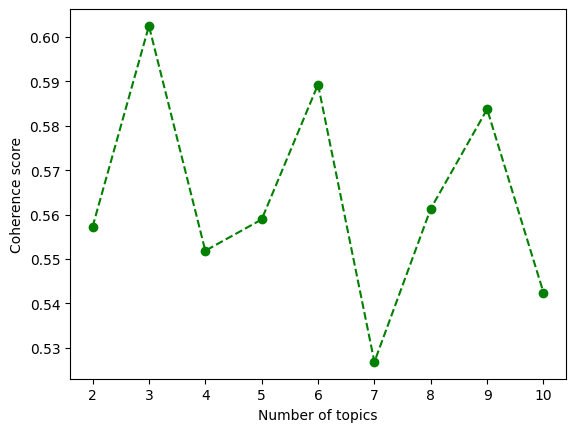

In [0]:
plt.plot(topic_num, cv_score, color='green', marker='o', linestyle='dashed')
plt.xticks(range(2, 1))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [0]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(corpus=corpus, id2word=id2word, num_topics=3, passes=10, random_state=42, per_word_topics=True)
clear_output()
print(" === print lda model === ")
print(lda_model)
print()
print(" === lda model topics === ")
pprint(lda_model.print_topics())
print()
print(" === lda coherence score === ")
coherence_score = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word , coherence='c_v')
print('\nCoherence Score: ', coherence_score.get_coherence())

 === print lda model === 
LdaModel<num_terms=9710, num_topics=3, decay=0.5, chunksize=2000>

 === lda model topics === 
[(0,
  '0.030*"phone" + 0.022*"note" + 0.021*"lenovo" + 0.018*"screen" + '
  '0.012*"call" + 0.011*"feature" + 0.009*"like" + 0.009*"option" + '
  '0.008*"money" + 0.008*"android"'),
 (1,
  '0.086*"good" + 0.059*"phone" + 0.055*"camera" + 0.041*"battery" + '
  '0.020*"quality" + 0.019*"nice" + 0.019*"mobile" + 0.018*"product" + '
  '0.015*"performance" + 0.015*"price"'),
 (2,
  '0.040*"phone" + 0.023*"problem" + 0.022*"mobile" + 0.021*"product" + '
  '0.020*"lenovo" + 0.018*"issue" + 0.017*"amazon" + 0.017*"worst" + '
  '0.014*"working" + 0.014*"battery"')]

 === lda coherence score === 

Coherence Score:  0.602501054811317


## What is the dominant topic in the corpus

In [0]:
topic_lookup_data = pd.DataFrame((lda_model.print_topics()), columns=['Topic_Number','Top_Keywords'])
topic_lookup_data['Topic_Name'] = ['Mix Problems','Nice Review','Battery Issue']
topic_lookup_data = topic_lookup_data[['Topic_Number', 'Topic_Name', 'Top_Keywords']]
topic_lookup_data['Top_Keywords'] = topic_lookup_data["Top_Keywords"].str.replace(r'[^a-z]', ' ', regex=True).apply(lambda x: x.split())
topic_lookup_data

,Topic_Number,Topic_Name,Top_Keywords
0,0,Mix Problems,"[phone, note, lenovo, screen, call, feature, like, option, money, android]"
1,1,Nice Review,"[good, phone, camera, battery, quality, nice, mobile, product, performance, price]"
2,2,Battery Issue,"[phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery]"


In [0]:
for index, sent in enumerate(lda_model[corpus[:3]]):
  print(index, sent[0])
  print()

0 [(0, 0.39524215), (1, 0.53263444), (2, 0.07212347)]

1 [(1, 0.13118067), (2, 0.85976684)]

2 [(0, 0.07215551), (1, 0.07081669), (2, 0.8570278)]



In [0]:
for index, sent in enumerate(lda_model[corpus]):
  topic_num =[]
  sent = sent[0]
  topic_details = sorted(sent, key=lambda x: x[1], reverse=True)[:2] # Getting top 2 topics in descending order
  topic_num.append(topic_details[0][0]) # Appending top topic
  if len(topic_details) > 1:
    if topic_details[1][1] > 0.35: # Appending second topic only if it has more than 35% influence on current row
      topic_num.append(topic_details[1][0])
  review_df.loc[index, 'Topic_Number'] = ','.join(str(x) for x in sorted(topic_num))

In [0]:
for index, topic_num in enumerate(review_df["Topic_Number"]):
  topic_name_list=[]
  for single_topic_num in topic_num.split(','):
    single_topic_num=int(single_topic_num)
    topic_name_list.append(topic_lookup_data.loc[topic_lookup_data["Topic_Number"] == single_topic_num, 'Topic_Name'][single_topic_num]) 
  review_df.loc[index, 'Topic_Name'] =' & '.join(topic_name_list)
  review_df.head()

/databricks/python_shell/dbruntime/safe_oinspect.py:133: DeprecationWarning: `getargspec` function is deprecated as of IPython 7.10and will be removed in future versions.
  argspec = oinspect.getargspec(obj)


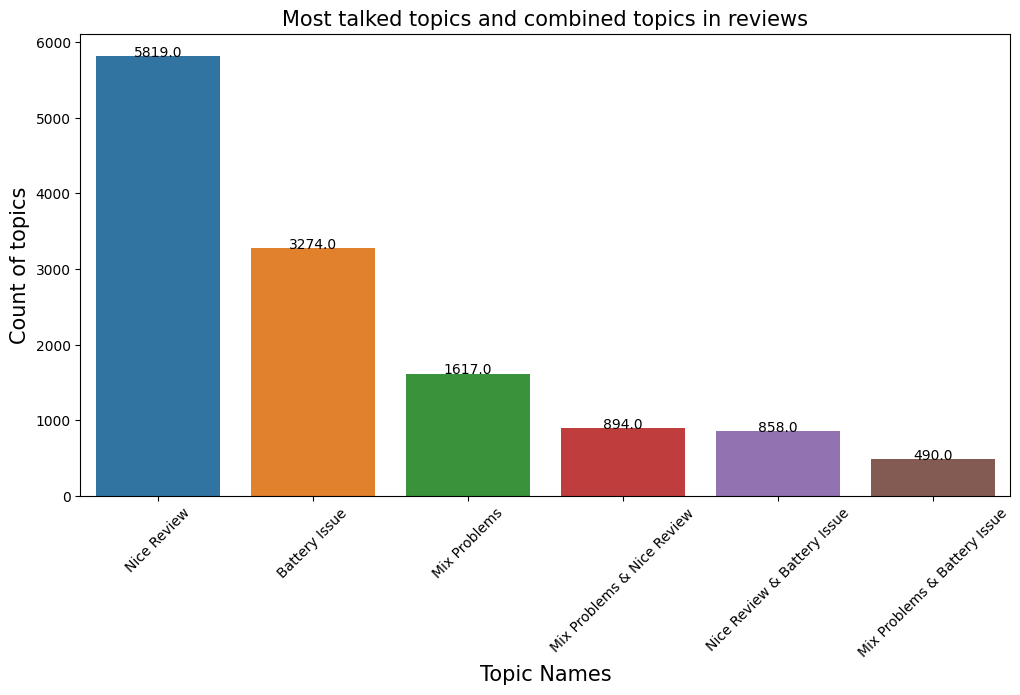

In [0]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=review_df["Topic_Name"].value_counts()[:6].index, y=review_df["Topic_Name"].value_counts()[:6].values)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+50),ha = 'center', va = 'center')
plt.xlabel('Topic Names',size=15)
plt.ylabel('Count of topics',size=15)
plt.xticks(rotation=45)
plt.title('Most talked topics and combined topics in reviews',size=15)
plt.show()

## What is the dominant topic and its percentage contribution in each document

In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=review_df['cleaned_review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=review_df['cleaned_review'])
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords_in_Topic_Group', 'Cleaned_Review']
df_dominant_topic.head(10)

/root/.ipykernel/1198/command-3928441893352538-692336401:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/root/.ipykernel/1198/command-3928441893352538-692336401:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic_Group,Cleaned_Review
0,1,0.5325,"good, phone, camera, battery, quality, nice, mobile, product, performance, price","[good, need, update, improvement]"
1,2,0.8598,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[worst, mobile, bought, ever, battery, draining, like, hell, backup, hour, internet, us, even, m..."
2,2,0.8570,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[cash, back, already, january]"
3,2,0.9510,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[worst, phone, everthey, changed, last, phone, problem, still, amazon, returning, phone, highly,..."
4,2,0.9117,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[telling, buyi, totally, disappointedpoor, batterypoor, camerawaste, money]"
5,2,0.4647,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[phone, awesome, charging, heat, allot, really, genuine, reason, hate, lenovo, note]"
6,1,0.8081,"good, phone, camera, battery, quality, nice, mobile, product, performance, price","[battery, level, worn]"
7,2,0.9545,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[hitting, problem, phone, hanging, problem, lenovo, note, service, station, ahmedabad, year, war..."
8,0,0.8669,"phone, note, lenovo, screen, call, feature, like, option, money, android","[glitch, dont, thing, better, option]"
9,2,0.7352,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[good, phone, charger, working, damage, within, month]"


In [0]:
merged_1 = review_df[['review', 'cleaned_review', 'Topic_Name']].merge(df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords_in_Topic_Group']], left_index=True, right_index=True)
merged_1 = merged_1.rename(columns={'review':'Review', 'cleaned_review':'Cleaned_Review'})
merged_1

,Review,Cleaned_Review,Topic_Name,Dominant_Topic,Topic_Perc_Contrib,Keywords_in_Topic_Group
0,Good but need updates and improvements,"[good, need, update, improvement]",Mix Problems & Nice Review,1,0.5325,"good, phone, camera, battery, quality, nice, mobile, product, performance, price"
1,"Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with...","[worst, mobile, bought, ever, battery, draining, like, hell, backup, hour, internet, us, even, m...",Battery Issue,2,0.8598,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery"
2,when I will get my 10% cash back.... its already 15 January..,"[cash, back, already, january]",Battery Issue,2,0.8570,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery"
3,The worst phone everThey have changed the last phone but the problem is still same and the amazo...,"[worst, phone, everthey, changed, last, phone, problem, still, amazon, returning, phone, highly,...",Battery Issue,2,0.9510,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery"
4,Only I'm telling don't buyI'm totally disappointedPoor batteryPoor cameraWaste of money,"[telling, buyi, totally, disappointedpoor, batterypoor, camerawaste, money]",Battery Issue,2,0.9117,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery"
...,...,...,...,...,...,...
12947,"I really like the phone, Everything is working fine whater I Use on the phone.","[really, like, phone, everything, working, fine, whater, phone]",Nice Review,1,0.9113,"good, phone, camera, battery, quality, nice, mobile, product, performance, price"
12948,The Lenovo K8 Note is awesome. It takes best pictures with dual camera. Very Slim and metallic b...,"[lenovo, note, awesome, take, best, picture, dual, camera, slim, metallic, body, difficult, hold...",Mix Problems & Nice Review,0,0.6069,"phone, note, lenovo, screen, call, feature, like, option, money, android"
12949,Awesome Gaget.. @ this price,"[awesome, gaget, price]",Nice Review,1,0.8330,"good, phone, camera, battery, quality, nice, mobile, product, performance, price"
12950,This phone is nice processing will be successful but dual camera is not be successfully in dual mod,"[phone, nice, processing, successful, dual, camera, successfully, dual]",Nice Review,1,0.6381,"good, phone, camera, battery, quality, nice, mobile, product, performance, price"


## The most representative sentence for each topic

In [0]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                             axis=0)
 
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9779,"phone, note, lenovo, screen, call, feature, like, option, money, android","[basic, important, feature, missing, sound, mute, vibrate, button, inbuilt, call, recording, gro..."
1,1,0.9861,"good, phone, camera, battery, quality, nice, mobile, product, performance, price","[phone, price, range, build, quality, phone, good, metallic, back, battery, phone, long, lasting..."
2,2,0.9924,"phone, problem, mobile, product, lenovo, issue, amazon, worst, working, battery","[purchased, middle, november, february, suddenly, stop, working, charging, happening, given, ser..."


## Frequency distribution of word counts in documents

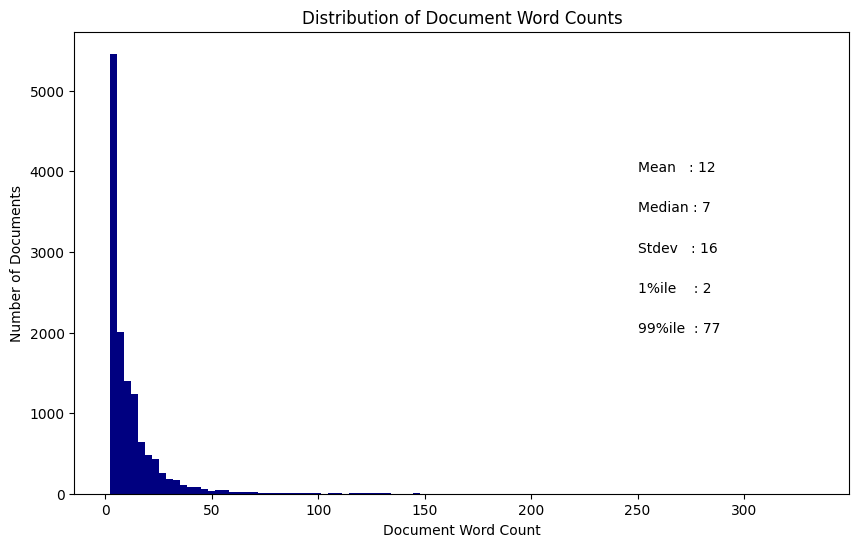

In [0]:
doc_lens = [len(d) for d in df_dominant_topic['Cleaned_Review']]

plt.figure(figsize=(10, 6))
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(250, 4000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(250, 3500, "Median : " + str(round(np.median(doc_lens))))
plt.text(250, 3000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(250, 2500, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(250, 2000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.ylabel('Number of Documents')
plt.xlabel('Document Word Count')
plt.title('Distribution of Document Word Counts')
plt.show()

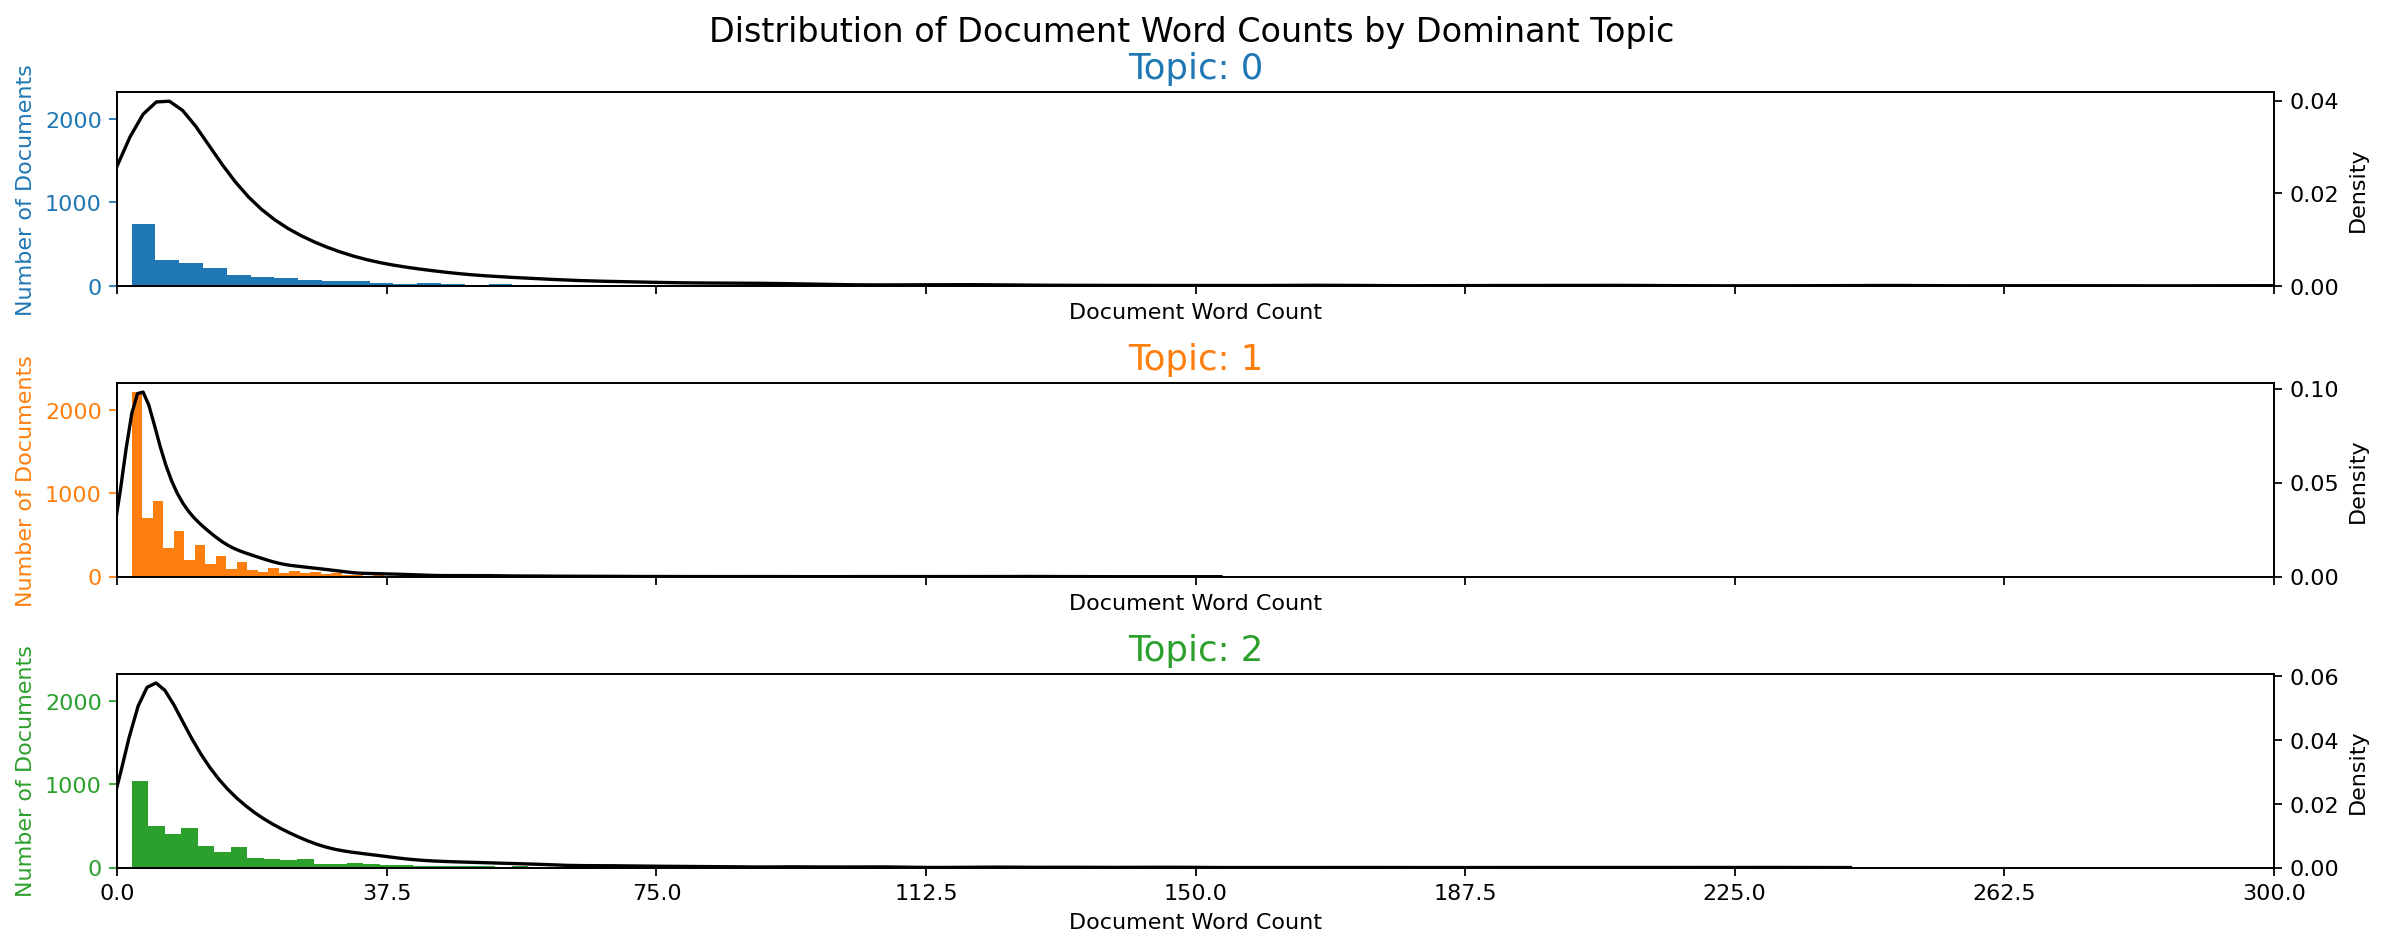

In [0]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

fig, axes = plt.subplots(3,1,figsize=(15, 6), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic["Dominant_Topic"] == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub["Cleaned_Review"]]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 300), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,300,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=15)
plt.show()

## Word clouds of top n keywords in each topic

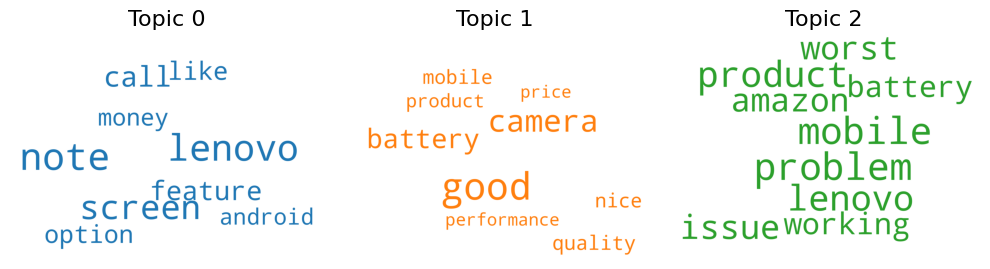

In [0]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

stop_words = stopwords.words('english')
stop_words.extend(['phone', 'mobile'])
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    topic_words.pop('phone')
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word counts of topic keywords

/root/.ipykernel/1198/command-3928441893352545-853362552:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/root/.ipykernel/1198/command-3928441893352545-853362552:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/root/.ipykernel/1198/command-3928441893352545-853362552:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


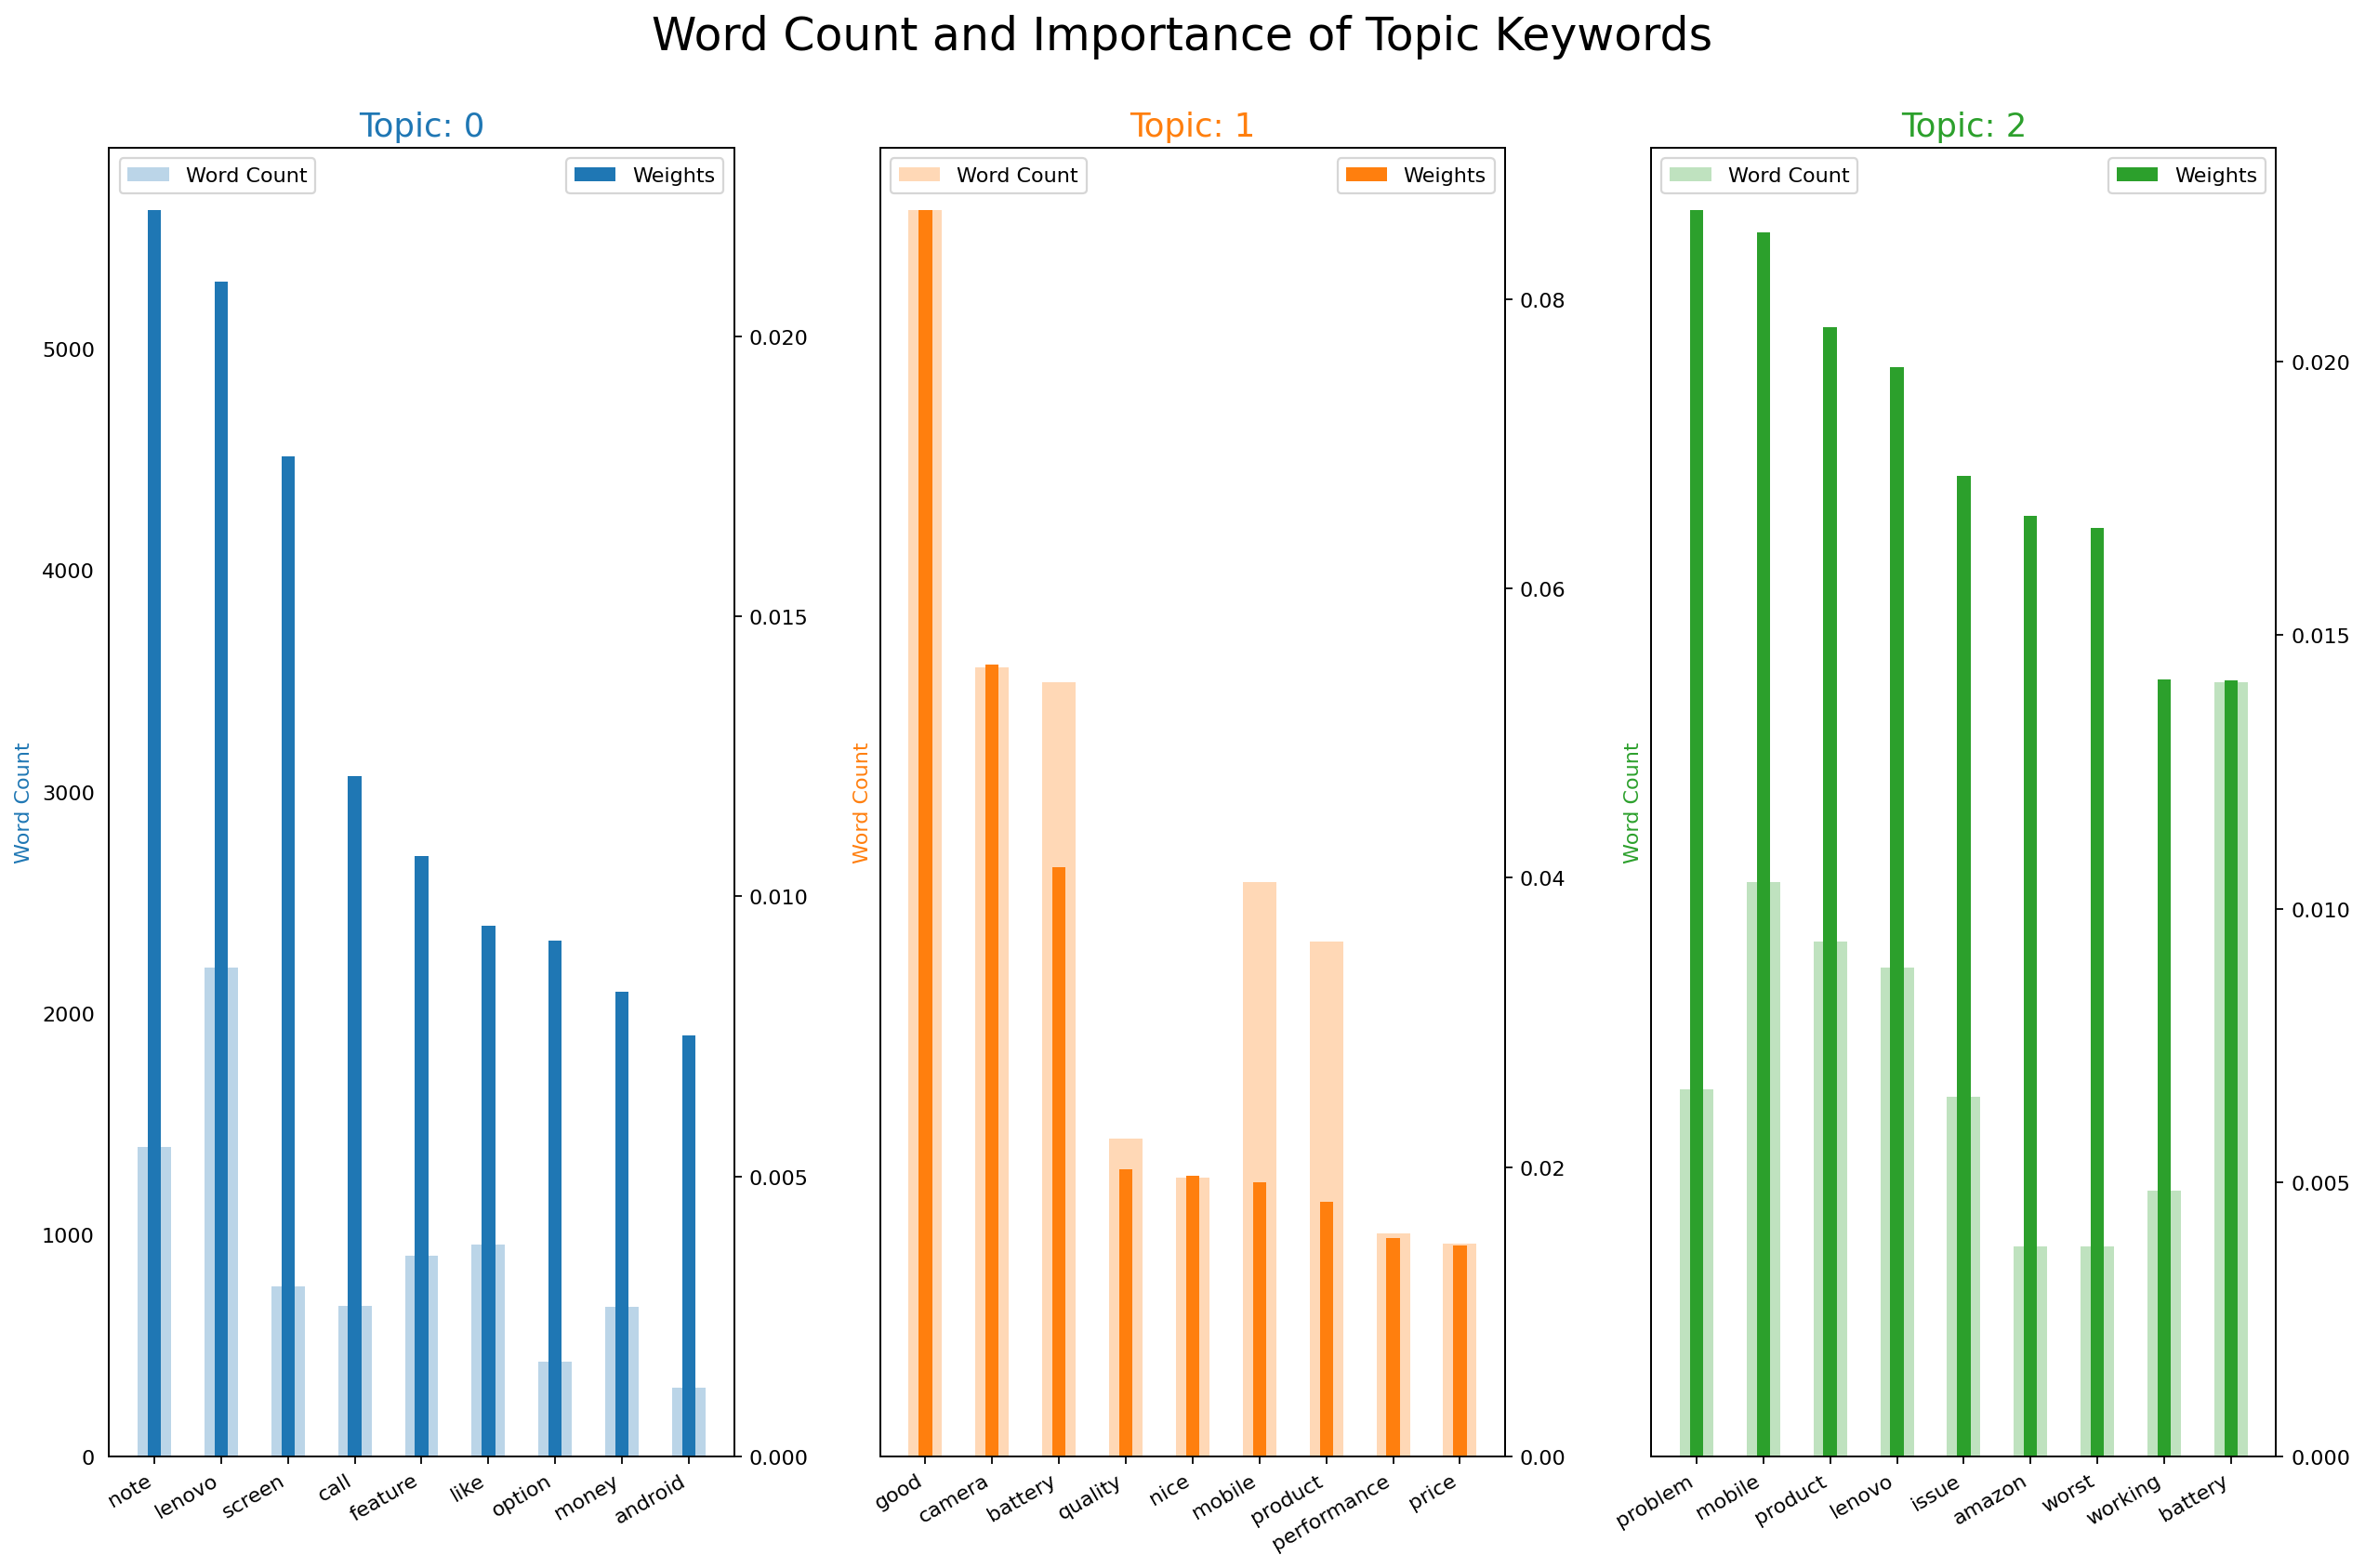

In [0]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in review_df['cleaned_review'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        if word != 'phone':
          out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

fig, axes = plt.subplots(1, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

##  Sentence chart colored by topic

In [0]:
topic_percs, wordid_topics, wordid_phivalues = lda_model[corpus[0]]
wordid_topics

[(0, [1]), (1, [1, 0]), (2, [0, 1, 2]), (3, [0, 1, 2])]

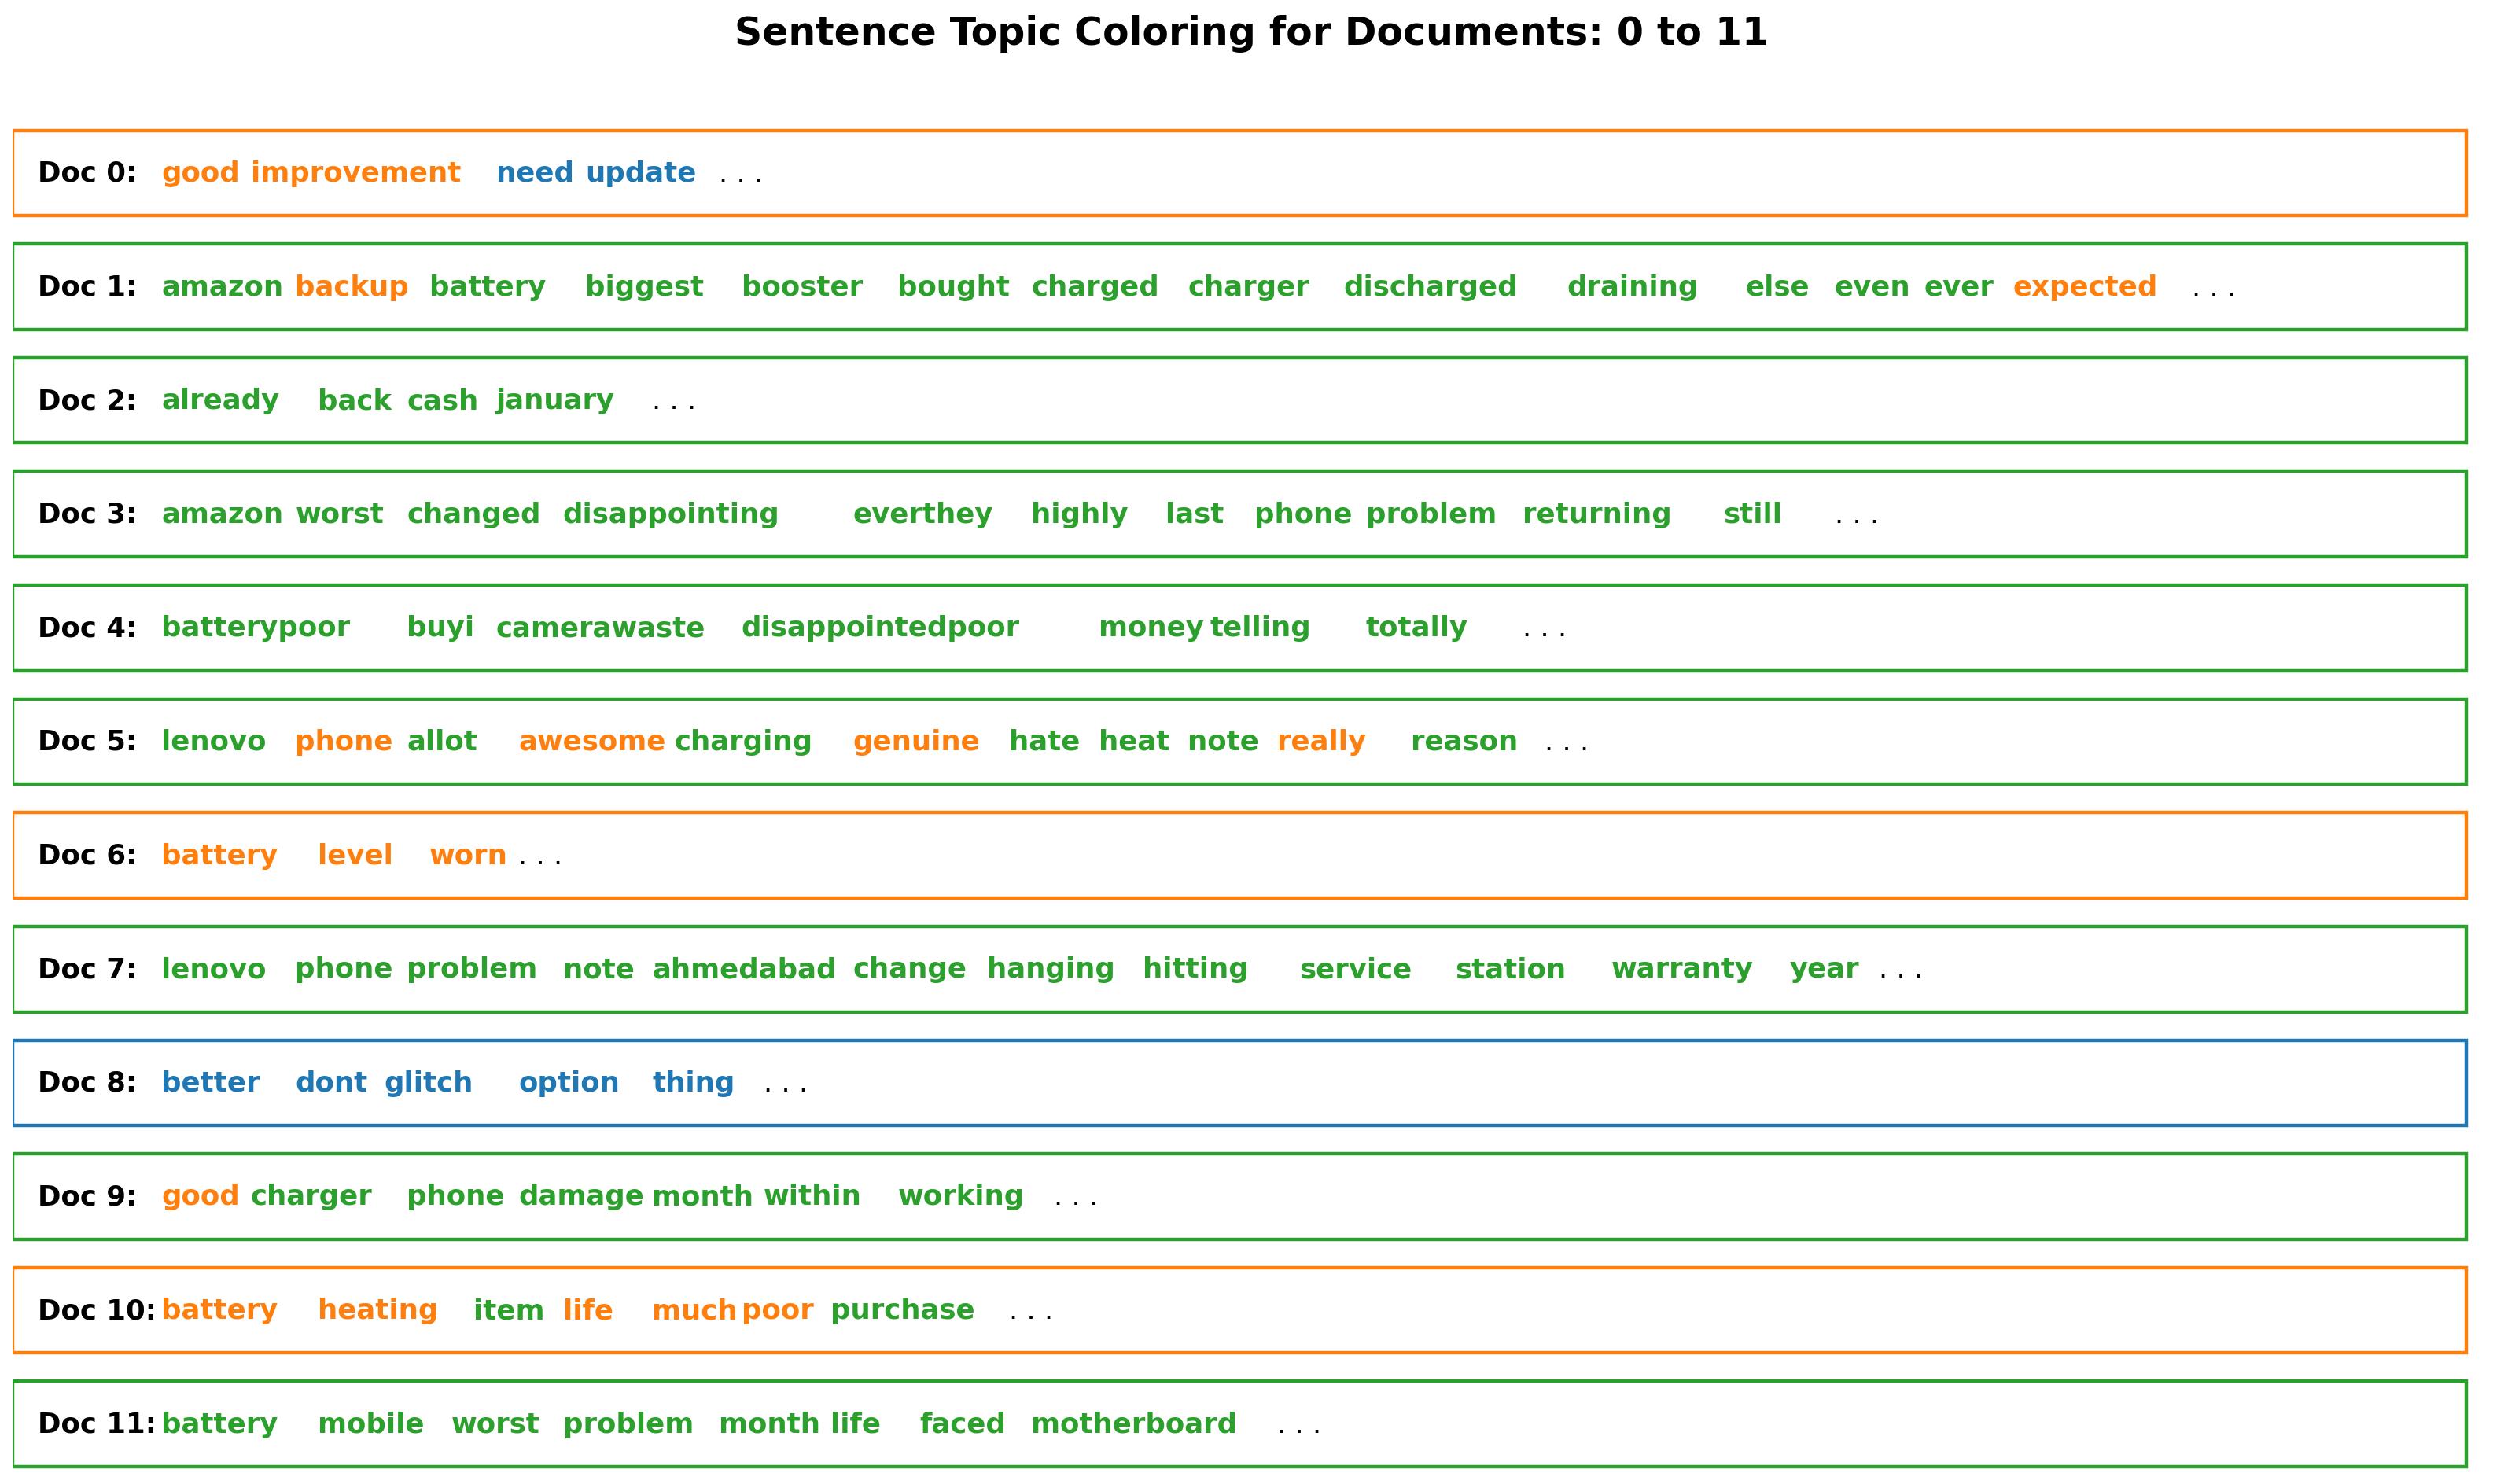

In [0]:
def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word) 
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

## What are the most discussed topics in the documents

In [0]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0] 
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

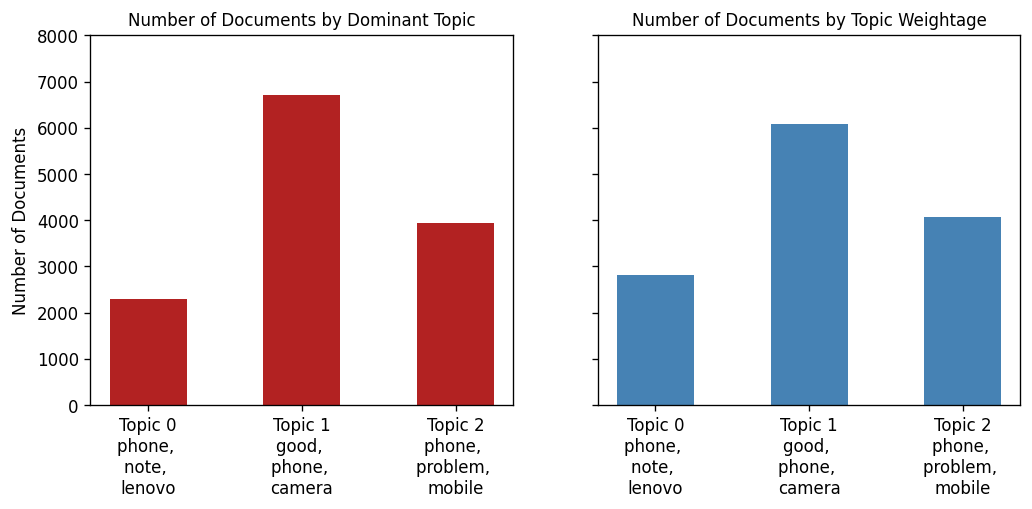

In [0]:
from matplotlib.ticker import FuncFormatter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 8000)

ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## t-SNE clustering chart

In [0]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700) 
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
html = file_html(plot, CDN, "my plot1")
displayHTML(html)

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12942 samples in 0.011s...
[t-SNE] Computed neighbors for 12942 samples in 0.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12942
[t-SNE] Computed conditional probabilities for sample 2000 / 12942
[t-SNE] Computed conditional probabilities for sample 3000 / 12942
[t-SNE] Computed conditional probabilities for sample 4000 / 12942
[t-SNE] Computed conditional probabilities for sample 5000 / 12942
[t-SNE] Computed conditional probabilities for sample 6000 / 12942
[t-SNE] Computed conditional probabilities for sample 7000 / 12942
[t-SNE] Computed conditional probabilities for sample 8000 / 12942
[t-SNE] Computed conditional probabilities for sample 9000 / 12942
[t-SNE] Computed conditional probabilities for sample 10000 / 12942
[t-SNE] Computed conditional probabilities for sample 11000 / 12942
[t-SNE] Computed conditional probabilities for sample 12000 / 12942
[t-SNE] Computed conditional probabilities for sam

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/databricks/python_shell/dbruntime/safe_oinspect.py:133: DeprecationWarning: `getargspec` function is deprecated as of IPython 7.10and will be removed in future versions.
  argspec = oinspect.getargspec(obj)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.804153
[t-SNE] KL divergence after 1000 iterations: 0.790592


Loading BokehJS ...

<!DOCTYPE html>
 
 
 
 my plot1

<img src="https://github.com/redcodebluecode/nlp/blob/251c1491e08bb3905b05be6d88027bae8dc4df1a/projects/nlp_amazon_review_topic_modeling/tSNE_1.JPG?raw=true" width="800">

## pyLDAVis

In [0]:
! pip install "pandas < 2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.0
    Uninstalling pandas-2.1.0:
      Successfully uninstalled pandas-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
databricks-feature-store 0.14.1 requires pyspark<4,>=3.1.2, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
ydata-profiling 4.2.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.4 which is incompatible.
mleap 0.20.0 requires scikit-learn<0.23.0,>=0.22.0, but you have scikit-learn 1.1.1 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.183014  0.109098       1        1  38.451714
2      0.012786 -0.198133       2        1  34.417744
0     -0.195800  0.089035       3        1  27.130542, topic_info=        Term         Freq        Total Category  logprob  loglift
0       good  5120.000000  5120.000000  Default  30.0000  30.0000
132   camera  3303.000000  3303.000000  Default  29.0000  29.0000
6    battery  3145.000000  3145.000000  Default  28.0000  28.0000
226     nice  1151.000000  1151.000000  Default  27.0000  27.0000
4     amazon   906.000000   906.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
79    better   277.433290   643.122999   Topic3  -5.0087   0.4638
480  support   182.822367   296.404219   Topic3  -5.4258   0.8213
87   working   236.990985  1153.070272   Topic3  -5.1662  -0.2777
15      even   205.416225   779.912618   Topic3  -5.3092  -0.0296
108     also   206.932083  1040.886025   Topic3  -5.3019  -0.3109

[212 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
108       1  0.453460     also
108       2  0.347781     also
108       3  0.198869     also
205       1  0.974700  amazing
205       3  0.021375  amazing
...     ...       ...      ...
87        2  0.648703  working
87        3  0.205538  working
39        1  0.001117    worst
39        2  0.998390    worst
39        3  0.001117    worst

[286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

<img src="https://github.com/redcodebluecode/nlp/blob/251c1491e08bb3905b05be6d88027bae8dc4df1a/projects/nlp_amazon_review_topic_modeling/pyLDAVis_1.JPG?raw=true" width="800">

# BERTopic

In [0]:
review_df['cleaned_review'] = review_df['review'].apply(lambda x: str(x).lower())
review_df['cleaned_review'] = review_df['cleaned_review'].str.replace(r'[^a-zA-Z\s]', ' ',regex=True) 
review_df['cleaned_review'] = review_df['cleaned_review'].str.replace(r'\s{2,}', ' ',regex=True)
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x: word_tokenize(x))
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x:[word for word in x if word not in stopwords.words("english") and len(word) > 3 and word.isalpha()])
review_df = review_df[review_df['cleaned_review'].map(lambda x: len(x)) > 1].reset_index(drop=True)
review_df['cleaned_review'] = review_df['cleaned_review'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])

def join_str(x):
  return ' '.join(x['cleaned_review'])

review_df['cleaned_review_str'] = review_df.apply(join_str, axis = 1)

print(review_df.head(5))
print()

docs = review_df['cleaned_review_str'].to_list()

                                              review  ...                                 cleaned_review_str
0             Good but need updates and improvements  ...                       good need update improvement
1  Worst mobile i have bought ever, Battery is dr...  ...  worst mobile bought ever battery draining like...
2  when I will get my 10% cash back.... its alrea...  ...                          cash back already january
3  The worst phone everThey have changed the last...  ...  worst phone everthey changed last phone proble...
4  Only I'm telling don't buyI'm totally disappoi...  ...  telling buyi totally disappointedpoor batteryp...

[5 rows x 3 columns]



## Search Document

In [0]:
model = BERTopic()
topics, probs = model.fit_transform(docs)
model.visualize_topics()

model.reduce_topics(docs, nr_topics=10)
model.visualize_topics()
similar_topics, similarity = model.find_topics("not recommended", top_n=5)
print(" === similar topics for not recommended === ")
print(similar_topics)
for i in similar_topics:
  print(model.get_topic(i))
  print()
print(" ******************************************************************************************************** ")

 === similar topics for not recommended === 
[2, 4, 0, -1, 1]
[('product', 0.2943441024800644), ('good', 0.1545673847140102), ('nice', 0.12175209271662069), ('money', 0.08061496736360921), ('value', 0.0768314732456609), ('price', 0.0734230817928337), ('performance', 0.0663999094283131), ('excellent', 0.05727416508097966), ('delivery', 0.053465757897091265), ('worth', 0.05236488262350797)]

[('waste', 0.5670128457870434), ('cash', 0.28293635979692117), ('money', 0.15844358424441393), ('back', 0.1505173118425497), ('product', 0.1124224057669242), ('return', 0.10450750722496366), ('want', 0.06394409380308141), ('hdfc', 0.05903515605506488), ('mobile', 0.058767899066558944), ('cashback', 0.05503215143858227)]

[('phone', 0.06879465961336757), ('good', 0.056375332351248184), ('camera', 0.05510667672004489), ('mobile', 0.043998754222069045), ('lenovo', 0.040465603088070484), ('nice', 0.030331675514664914), ('battery', 0.029229241440536936), ('quality', 0.028467531382507884), ('note', 0.02719

## Interactive Visualization

In [0]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

topic_model = BERTopic().fit(docs, embeddings)
topic_model.reduce_topics(docs, nr_topics=10)

topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, optional but much faster to run:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(doc, reduced_embeddings = reduced_embeddings)

<img src="https://github.com/redcodebluecode/nlp/blob/main/projects/nlp_amazon_review_topic_modeling/BERTopic_1.JPG?raw=true" width="800">

In [0]:
topic_model.get_topic_freq()

,Topic,Count
0,0,5100
3,-1,4180
2,1,1787
4,2,1351
8,3,166
6,4,161
1,5,83
7,6,60
5,7,48
9,8,16


In [0]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4180,-1_phone_good_camera_battery,"[phone, good, camera, battery, lenovo, mobile,...",[battery back poor sound quality also good len...
1,0,5100,0_phone_good_camera_lenovo,"[phone, good, camera, lenovo, mobile, nice, no...","[good phone, phone good, phone good camera bat..."
2,1,1787,1_battery_heating_charging_problem,"[battery, heating, charging, problem, phone, i...","[good mobile phone heating charging, heating b..."
3,2,1351,2_product_good_nice_price,"[product, good, nice, price, money, value, per...","[good product, good product, good product]"
4,3,166,3_network_problem_signal_wifi,"[network, problem, signal, wifi, issue, hotspo...","[network problem, network problem, network pro..."
5,4,161,4_bahut_bekar_nahi_raha,"[bahut, bekar, nahi, raha, ghatiya, phone, hot...","[bahut bekar, kuch sahi heating bahut krta pho..."
6,5,83,5_waste_cash_money_back,"[waste, cash, money, back, product, mobile, ca...","[waste money, waste phone, waste waste waste w..."
7,6,60,6_bill_invoice_copy_want,"[bill, invoice, copy, want, mail, email, need,...","[want invoice bill urgently, invoice bill give..."
8,7,48,7_volta_support_network_supported,"[volta, support, network, supported, phone, ba...","[phone volta support, phone volta, phone good ..."
9,8,16,8_heavy_weight_size_comfortable,"[heavy, weight, size, comfortable, normal, wea...","[satisfied heavy, bulky heavy weight look good..."


In [0]:
model.save("/dbfs/FileStore/tables/bt_model")
# to load
# model = BERTopic.load("/dbfs/FileStore/tables/bt_model")

/databricks/python/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

